## Machine Learning Explainability: Interpretable Models

*Prepared by:*  
**Jude Michael Teves**  
Faculty, Software Technology Department  
College of Computer Studies - De La Salle University

## Preliminaries

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import seaborn as sns

sns.set_style('darkgrid')

sns.set_palette('Set2')
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

We will be using the Titanic dataset in this notebook.

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Cyntwikip/data-repository/main/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
from sklearn.impute import SimpleImputer

X = df.drop(['Survived','PassengerId','Name','Ticket','Cabin'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cols = X_train.columns
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = pd.DataFrame(imp_mean.transform(X_train), columns=cols)
X_test = pd.DataFrame(imp_mean.transform(X_test), columns=cols)

print(f"Train Set Size | Input: {X_train.shape}, Output: {y_train.shape}")
print(f"Test Set Size | Input: {X_test.shape}, Output: {y_test.shape}")

Train Set Size | Input: (712, 8), Output: (712,)
Test Set Size | Input: (179, 8), Output: (179,)


## Intrepretable Models

To achieve model interpretability, one of the simplest approaches is to use models that are inherently interpretable. Common models in this category include linear regression, logistic regression, and decision trees.

### Linear

Linear regression models predict the target variable as a weighted sum of the input features. This linearity makes interpretation straightforward, which is why these models have been used for decades by statisticians and data scientists alike. For a single instance, the relationship is expressed as:

$$y = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p + \epsilon$$

In this equation, each feature $x_i$ contributes to the outcome $y$ by its corresponding weight $\beta_i$. Linear models, however, are limited to capturing only linear relationships. If there are nonlinear interactions, they must be manually added as features.

Also take note of linear regression assumptions: linearity, homoscedasticity, normality of errors, and no multicollinearity.

#### Interpretation

As mentioned, this is very straightforward. For every one-unit increase in a feature $x_i$, the predicted outcome changes by $\beta_i$.

In the dataset we are using, we will use Logistic Regression as this is a classification problem but the same concept applies for both Linear and Logistic Regression.



In [4]:
# code here
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=cols)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
print("Score:", model.score(X_test_scaled, y_test))
pd.Series(model.coef_[0], index=model.feature_names_in_).sort_values(ascending=False)

Score: 0.8100558659217877


,0
Fare,0.122951
Embarked_Q,-0.043312
Parch,-0.097871
Embarked_S,-0.198737
SibSp,-0.350138
Age,-0.405348
Pclass,-0.787073
Sex_male,-1.274988


#### Feature Importance

We can check the most important features by looking at the absolute values of the coefficients.

In [5]:
# model.predict_proba(X_test)
# model.predict(X_test)
coefs = pd.Series(model.coef_[0], index=model.feature_names_in_)
sorted_coefs = coefs.abs().sort_values(ascending=True)
coefs[sorted_coefs.index]

,0
Embarked_Q,-0.043312
Parch,-0.097871
Fare,0.122951
Embarked_S,-0.198737
SibSp,-0.350138
Age,-0.405348
Pclass,-0.787073
Sex_male,-1.274988


Text(0.5, 1.0, 'Feature Importance')

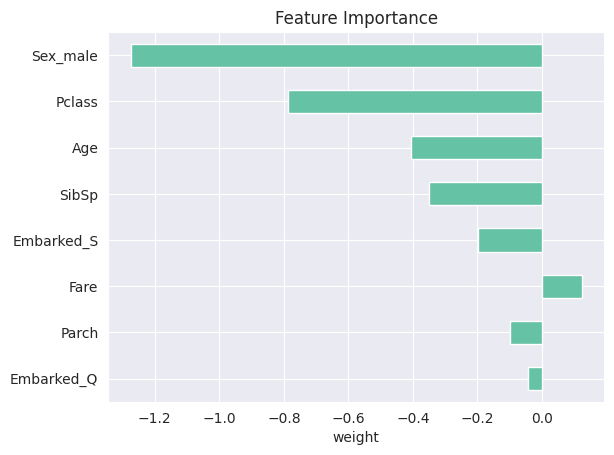

In [6]:
coefs[sorted_coefs.index].plot(kind='barh')
plt.xlabel('weight')
plt.title('Feature Importance')

As you can see, if the sex is male, the survival rate decreases significantly.

### Tree-based Models

Linear models struggle when the relationships between features and outcomes are nonlinear. In these cases, decision trees shine. A decision tree splits the data based on certain feature thresholds, forming subsets until reaching terminal nodes (leaf nodes). Each leaf node predicts an outcome based on the average of the training data within that node.

In [7]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)
print("Score:", model.score(X_test, y_test))

Score: 0.7988826815642458


#### Interpretation

Interpreting a decision tree is intuitive. Starting at the root, we follow branches based on the feature values, eventually reaching a leaf node that gives the prediction. The interpretation follows an "AND" logic at each split.

In [8]:
model

DecisionTreeClassifier(max_depth=3, random_state=42)

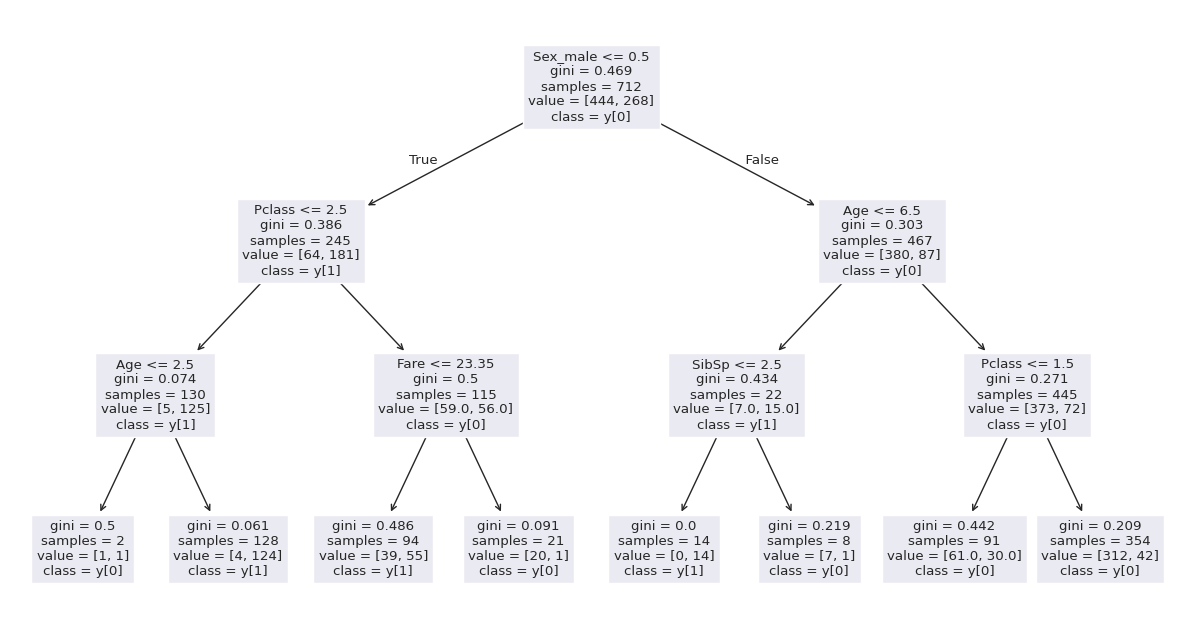

In [10]:
from sklearn import tree

plt.figure(figsize=(15,8))

tree.plot_tree(model, feature_names=list(cols), class_names=True)
plt.show()




#### Feature Importance

The importance of a feature in a decision tree is determined by how much it reduces the impurity across all splits that use that feature. The importances are normalized to sum to 100%, allowing interpretation of each feature's relative contribution to the overall model.



In [11]:
coefs = pd.Series(model.feature_importances_, index=model.feature_names_in_)
sorted_coefs = coefs.abs().sort_values(ascending=True)
coefs[sorted_coefs.index]

,0
Parch,0.000000
Embarked_Q,0.000000
Embarked_S,0.000000
SibSp,0.048135
Fare,0.061240
Age,0.075353
Pclass,0.209536
Sex_male,0.605737


Text(0.5, 1.0, 'Feature Importance')

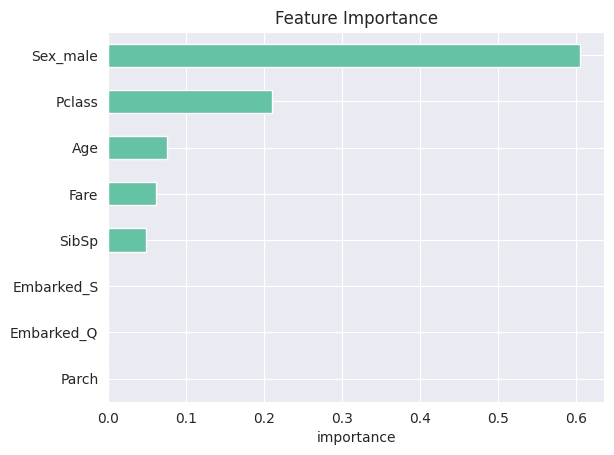

In [12]:
coefs[sorted_coefs.index].plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

## End
<sup>made by **Jude Michael Teves**</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> <href>judemichaelteves@gmail.com</href> or <href>jude.teves@dlsu.edu.ph</href></sup><br>
